In [ ]:
# Install required libraries
!pip install -q transformers albumentations opencv-python tqdm
!pip install torchmetrics

from google.colab import drive
drive.mount('/content/gdrive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
#necessary imports
import os
import cv2
import numpy as np
from glob import glob
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassJaccardIndex
from transformers import SegformerForSemanticSegmentation
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.optim import AdamW

import random


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define label mappings (modify if you have more classes)
id2label = {0: "background", 1: "road"}
label2id = {"background": 0, "road": 1}
NUM_CLASSES = len(id2label)

NUM_EPOCHS = 15
LEARNING_RATE = 5e-5  # Half of original rate, but higher than typical fine-tuning
BATCH_SIZE = 8
IMG_HEIGHT = 400
IMG_WIDTH = 400


Using device: cuda


In [ ]:
# Initialize the model architecture
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b2-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# Load the saved state dictionary
model.load_state_dict(torch.load("/content/gdrive/MyDrive/Road Segmentation/segformer_model_epochs_25.pt"))

# Move the model to the appropriate device
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [ ]:
#on the fly transformations
train_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),  # Add some noise augmentation
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),
    ], p=0.3),  # Geometric distortions can help with road segmentation
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.3),  # Color variations
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

<ipython-input-4-397a466ffa21>:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
<ipython-input-4-397a466ffa21>:12: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),


In [ ]:

class RoadSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_paths = sorted(glob(os.path.join(images_dir, "*")))
        self.masks_paths = sorted(glob(os.path.join(masks_dir, "*")))
        self.transform = transform

        assert len(self.images_paths) == len(self.masks_paths), "Mismatch between images and masks count."

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        # Load image and convert to RGB
        image = cv2.imread(self.images_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask in grayscale
        mask = cv2.imread(self.masks_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask > 127, 1, 0).astype(np.uint8)

        # Apply transformations if any
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
"""import os

# Define your directories
images_dir = '/content/gdrive/MyDrive/Road Segmentation/images'
masks_dir = '/content/gdrive/MyDrive/Road Segmentation/groundtruth'

# List all files in each directory
image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))

# Normalize filenames by removing extensions
image_basenames = set(os.path.splitext(f)[0] for f in image_files)
mask_basenames = set(os.path.splitext(f)[0] for f in mask_files)
"""

"import os\n\n# Define your directories\nimages_dir = '/content/gdrive/MyDrive/Road Segmentation/images'\nmasks_dir = '/content/gdrive/MyDrive/Road Segmentation/groundtruth'\n\n# List all files in each directory\nimage_files = sorted(os.listdir(images_dir))\nmask_files = sorted(os.listdir(masks_dir))\n\n# Normalize filenames by removing extensions\nimage_basenames = set(os.path.splitext(f)[0] for f in image_files)\nmask_basenames = set(os.path.splitext(f)[0] for f in mask_files)\n"

In [ ]:
"""# Images without corresponding masks
missing_masks = image_basenames - mask_basenames
if missing_masks:
    print("Images without corresponding masks:")
    for name in missing_masks:
        print(f"{name}")

# Masks without corresponding images
missing_images = mask_basenames - image_basenames
if missing_images:
    print("\nMasks without corresponding images:")
    for name in missing_images:
        print(f"{name}")
"""

'# Images without corresponding masks\nmissing_masks = image_basenames - mask_basenames\nif missing_masks:\n    print("Images without corresponding masks:")\n    for name in missing_masks:\n        print(f"{name}")\n\n# Masks without corresponding images\nmissing_images = mask_basenames - image_basenames\nif missing_images:\n    print("\nMasks without corresponding images:")\n    for name in missing_images:\n        print(f"{name}")\n'

In [ ]:
# Update the paths to point to your dataset
IMAGES_DIR = '/content/gdrive/MyDrive/Road Segmentation/images'
MASKS_DIR = '/content/gdrive/MyDrive/Road Segmentation/groundtruth'

import os

file_path = '/content/gdrive/MyDrive/Road Segmentation/groundtruth/boston_2363.png'

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Deleted: {file_path}")
else:
    print(f"File not found: {file_path}")

# Create the full dataset without transformations
full_dataset = RoadSegmentationDataset(IMAGES_DIR, MASKS_DIR, transform=None)

# Generate indices for splitting
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
train_indices, temp_indices = train_test_split(indices, test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Create subsets with appropriate transformations
train_dataset = Subset(RoadSegmentationDataset(IMAGES_DIR, MASKS_DIR, transform=train_transform), train_indices)
val_dataset = Subset(RoadSegmentationDataset(IMAGES_DIR, MASKS_DIR, transform=val_test_transform), val_indices)
test_dataset = Subset(RoadSegmentationDataset(IMAGES_DIR, MASKS_DIR, transform=val_test_transform), test_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Print dataset sizes
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

File not found: /content/gdrive/MyDrive/Road Segmentation/groundtruth/boston_2363.png
Number of training samples: 2800
Number of validation samples: 600
Number of test samples: 600


In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
#history dict to store metrics per epoch
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': [],
    'train_iou': [],
    'val_iou': [],
    'train_dice': [],
    'val_dice': []
}

In [ ]:
def calculate_dice_score(pred, target, num_classes=2, smooth=1e-6):
    dice_scores = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = torch.sum(pred_cls * target_cls)
        union = torch.sum(pred_cls) + torch.sum(target_cls)
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())
    return sum(dice_scores) / len(dice_scores)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    acc_metric = MulticlassAccuracy(num_classes=NUM_CLASSES).to(device)
    f1_metric = MulticlassF1Score(num_classes=NUM_CLASSES).to(device)
    iou_metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES).to(device)
    dice_total = 0.0

    for images, masks in tqdm(loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device, dtype=torch.long) # Change data type to torch.long
        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)

        # Update metrics
        acc_metric.update(preds, masks)
        f1_metric.update(preds, masks)
        iou_metric.update(preds, masks)
        dice_total += calculate_dice_score(preds, masks, NUM_CLASSES) * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = acc_metric.compute().item()
    epoch_f1 = f1_metric.compute().item()
    epoch_iou = iou_metric.compute().item()
    epoch_dice = dice_total / len(loader.dataset)
    return epoch_loss, epoch_acc, epoch_f1, epoch_iou, epoch_dice


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    acc_metric = MulticlassAccuracy(num_classes=NUM_CLASSES).to(device)
    f1_metric = MulticlassF1Score(num_classes=NUM_CLASSES).to(device)
    iou_metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES).to(device)
    dice_total = 0.0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validating", leave=False):
            images, masks = images.to(device), masks.to(device, dtype=torch.long) # Change data type to torch.long
            outputs = model(pixel_values=images).logits
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            acc_metric.update(preds, masks)
            f1_metric.update(preds, masks)
            iou_metric.update(preds, masks)
            dice_total += calculate_dice_score(preds, masks, NUM_CLASSES) * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = acc_metric.compute().item()
    epoch_f1 = f1_metric.compute().item()
    epoch_iou = iou_metric.compute().item()
    epoch_dice = dice_total / len(loader.dataset)
    return epoch_loss, epoch_acc, epoch_f1, epoch_iou, epoch_dice

In [ ]:
best_val_loss = float('inf')
patience = 10
early_stopping_counter = 0
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc, train_f1, train_iou, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1, val_iou, val_dice = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    # Store metrics in history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)

    # Logging
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
    print(f"Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f}")
    print(f"Train Dice: {train_dice:.4f} | Val Dice: {val_dice:.4f}")

    # Early stopping and checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), f"/content/gdrive/MyDrive/Road Segmentation/srs_finetuned_segformer_model_epochs_{NUM_EPOCHS}.pt")
        print("Saved best model")
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.2252 | Val Loss: 0.1868
Train Acc: 0.7947 | Val Acc: 0.8280
Train F1: 0.8199 | Val F1: 0.8523
Train IoU: 0.7162 | Val IoU: 0.7575
Train Dice: 0.8188 | Val Dice: 0.8516
Saved best model
Epoch 2/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1884 | Val Loss: 0.1782
Train Acc: 0.8196 | Val Acc: 0.8322
Train F1: 0.8428 | Val F1: 0.8563
Train IoU: 0.7455 | Val IoU: 0.7629
Train Dice: 0.8416 | Val Dice: 0.8555
Saved best model
Epoch 3/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1782 | Val Loss: 0.1700
Train Acc: 0.8295 | Val Acc: 0.8498
Train F1: 0.8512 | Val F1: 0.8667
Train IoU: 0.7565 | Val IoU: 0.7770
Train Dice: 0.8501 | Val Dice: 0.8657
Saved best model
Epoch 4/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1727 | Val Loss: 0.1681
Train Acc: 0.8354 | Val Acc: 0.8477
Train F1: 0.8564 | Val F1: 0.8662
Train IoU: 0.7634 | Val IoU: 0.7764
Train Dice: 0.8553 | Val Dice: 0.8652
Saved best model
Epoch 5/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1685 | Val Loss: 0.1653
Train Acc: 0.8388 | Val Acc: 0.8512
Train F1: 0.8598 | Val F1: 0.8697
Train IoU: 0.7681 | Val IoU: 0.7813
Train Dice: 0.8593 | Val Dice: 0.8687
Saved best model
Epoch 6/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1648 | Val Loss: 0.1600
Train Acc: 0.8421 | Val Acc: 0.8587
Train F1: 0.8623 | Val F1: 0.8749
Train IoU: 0.7716 | Val IoU: 0.7886
Train Dice: 0.8611 | Val Dice: 0.8741
Saved best model
Epoch 7/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1618 | Val Loss: 0.1621
Train Acc: 0.8452 | Val Acc: 0.8478
Train F1: 0.8651 | Val F1: 0.8702
Train IoU: 0.7754 | Val IoU: 0.7821
Train Dice: 0.8640 | Val Dice: 0.8692
Early stopping counter: 1/10
Epoch 8/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1598 | Val Loss: 0.1559
Train Acc: 0.8475 | Val Acc: 0.8521
Train F1: 0.8670 | Val F1: 0.8759
Train IoU: 0.7781 | Val IoU: 0.7902
Train Dice: 0.8659 | Val Dice: 0.8750
Saved best model
Epoch 9/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1564 | Val Loss: 0.1556
Train Acc: 0.8509 | Val Acc: 0.8711
Train F1: 0.8700 | Val F1: 0.8811
Train IoU: 0.7823 | Val IoU: 0.7974
Train Dice: 0.8691 | Val Dice: 0.8802
Saved best model
Epoch 10/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1552 | Val Loss: 0.1565
Train Acc: 0.8520 | Val Acc: 0.8627
Train F1: 0.8707 | Val F1: 0.8778
Train IoU: 0.7832 | Val IoU: 0.7927
Train Dice: 0.8698 | Val Dice: 0.8770
Early stopping counter: 1/10
Epoch 11/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1534 | Val Loss: 0.1550
Train Acc: 0.8540 | Val Acc: 0.8642
Train F1: 0.8724 | Val F1: 0.8792
Train IoU: 0.7856 | Val IoU: 0.7948
Train Dice: 0.8716 | Val Dice: 0.8785
Saved best model
Epoch 12/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1509 | Val Loss: 0.1553
Train Acc: 0.8562 | Val Acc: 0.8667
Train F1: 0.8744 | Val F1: 0.8808
Train IoU: 0.7884 | Val IoU: 0.7971
Train Dice: 0.8736 | Val Dice: 0.8800
Early stopping counter: 1/10
Epoch 13/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1499 | Val Loss: 0.1531
Train Acc: 0.8572 | Val Acc: 0.8677
Train F1: 0.8751 | Val F1: 0.8821
Train IoU: 0.7895 | Val IoU: 0.7990
Train Dice: 0.8740 | Val Dice: 0.8815
Saved best model
Epoch 14/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1479 | Val Loss: 0.1530
Train Acc: 0.8585 | Val Acc: 0.8718
Train F1: 0.8762 | Val F1: 0.8838
Train IoU: 0.7909 | Val IoU: 0.8013
Train Dice: 0.8749 | Val Dice: 0.8830
Saved best model
Epoch 15/15


Training:   0%|          | 0/350 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Train Loss: 0.1467 | Val Loss: 0.1532
Train Acc: 0.8603 | Val Acc: 0.8782
Train F1: 0.8779 | Val F1: 0.8834
Train IoU: 0.7933 | Val IoU: 0.8007
Train Dice: 0.8768 | Val Dice: 0.8826
Early stopping counter: 1/10


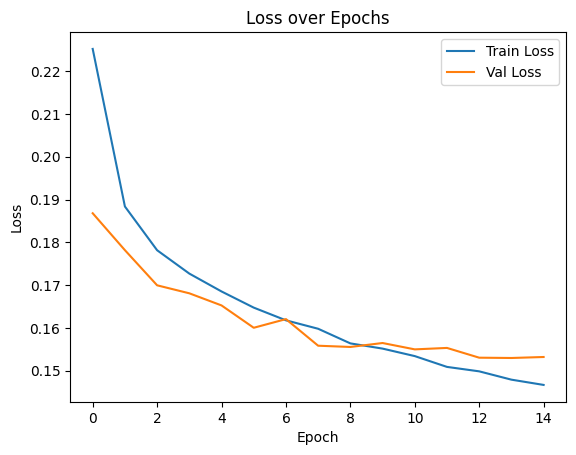

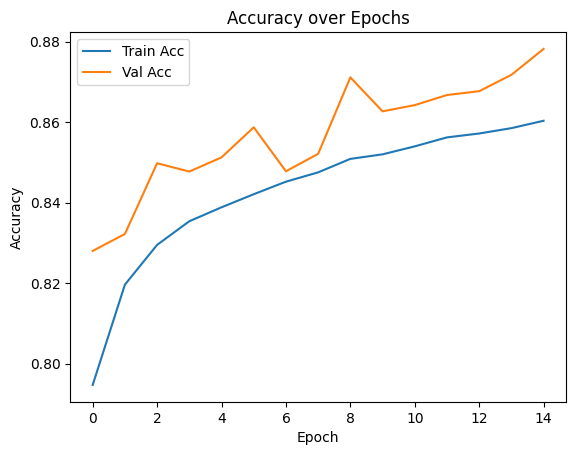

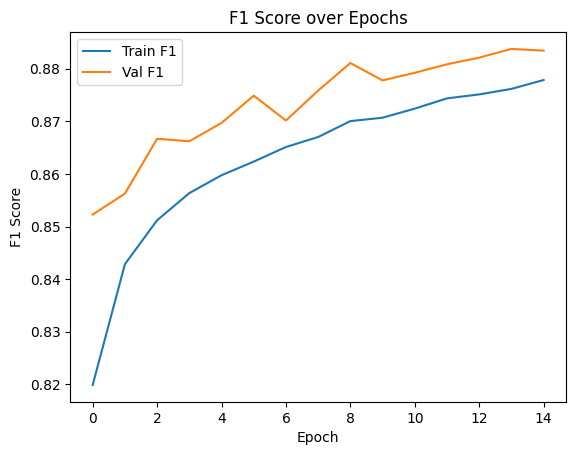

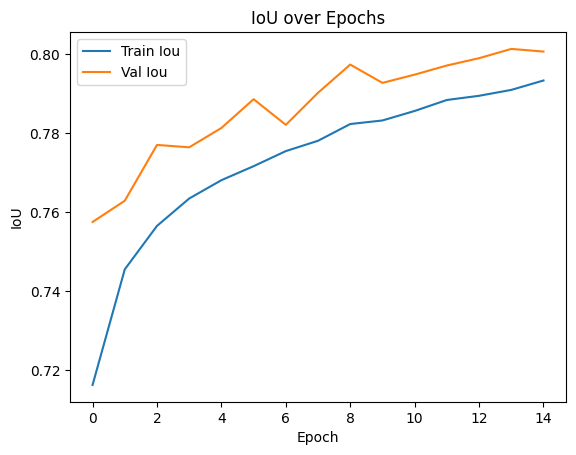

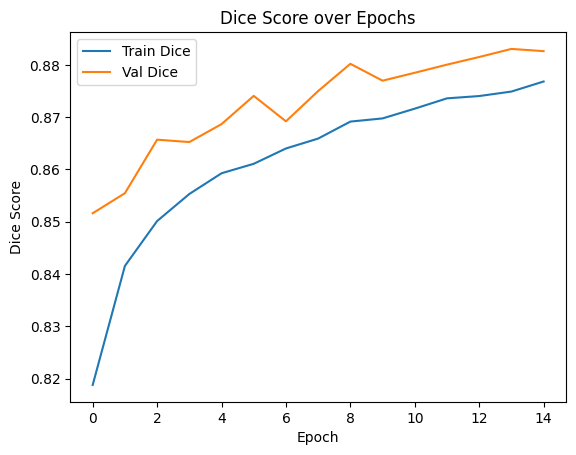

In [ ]:
# Plotting metrics
import matplotlib.pyplot as plt

def plot_metric(name, ylabel):
    plt.figure()
    plt.plot(history[f'train_{name}'], label=f'Train {name.capitalize()}')
    plt.plot(history[f'val_{name}'], label=f'Val {name.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(f'{ylabel} over Epochs')
    plt.show()

plot_metric('loss', 'Loss')
plot_metric('acc', 'Accuracy')
plot_metric('f1', 'F1 Score')
plot_metric('iou', 'IoU')
plot_metric('dice', 'Dice Score')

In [ ]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import cv2

# Define the directory to save predictions
PREDICTIONS_DIR = '/content/gdrive/MyDrive/Road Segmentation/predictions_for_srs_data'
os.makedirs(PREDICTIONS_DIR, exist_ok=True)

# Ensure the model is in evaluation mode
model.eval()

# Loop through each test sample and save the predicted mask
for idx, (image, _) in enumerate(tqdm(test_loader, desc="Running Inference on Test Set")):
    image = image.to(device)  # Move image to the appropriate device

    with torch.no_grad():
        logits = model(image).logits  # Forward pass
        # Resize logits to match original image size if necessary
        logits = F.interpolate(logits, size=image.shape[2:], mode='bilinear', align_corners=False)

        # Iterate through batch to handle each image individually
        for i in range(logits.shape[0]):
            prediction = torch.argmax(logits[i], dim=0).cpu().numpy()  # Get prediction for current image in batch

            # Generate a color mask with distinct colors
            prediction_mask_colored = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)

            # Map classes to colors (add more if needed)
            prediction_mask_colored[prediction == 0] = [0, 0, 0]    # Background (Black)
            prediction_mask_colored[prediction == 1] = [255, 0, 0]  # Road (Red)

            # Save the color mask with a unique filename
            save_path = os.path.join(PREDICTIONS_DIR, f"prediction_{idx}_{i}.png")  # Add batch index to filename
            cv2.imwrite(save_path, prediction_mask_colored)

Running Inference on Test Set: 100%|██████████| 75/75 [04:19<00:00,  3.46s/it]


In [ ]:
import cv2

# Select a sample index to visualize
sample_idx = 0

# Retrieve the original image and corresponding prediction
orig_image, _ = test_dataset[sample_idx]
orig_image_np = orig_image.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization

# Load the saved prediction mask, adding batch index 0 to match the save pattern
mask_path = os.path.join(PREDICTIONS_DIR, f"prediction_{sample_idx}_0.png")  # Update the mask path
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Check if the mask was loaded successfully
if mask is None:
    print(f"Error: Could not load mask from {mask_path}. Check if the file exists and is a valid image.")
else:
    # Plot the original image and the predicted mask side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(orig_image_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Predicted Road Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()